## ResNet50 Model Training Porocess

### Import libraries

In [38]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [39]:
train_path = 'split_data/train'
valid_path = 'split_data/val'
test_path = 'split_data/test'

### Training classes

In [40]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [41]:
train_batch_size = 8
test_batch_size = 8
valid_batch_size = 8

### Training samples

In [65]:
# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 1870
Test samples: 401
Validation samples: 401


In [43]:

train_n = 1870
test_n = 401
valid_n = 401

### Training steps (per epoch)

In [44]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [45]:
epochs = 10

### Generate batches

In [46]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 1870 images belonging to 9 classes.
Found 401 images belonging to 9 classes.
Found 401 images belonging to 9 classes.


### Base model (ResNet50)

#### Training from scratch

In [47]:
base_model = tf.keras.applications.ResNet50(include_top=False,
    weights=None,
    pooling='avg')

In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
output =  tf.keras.layers.Dense(len(train_classes), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [50]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

### Generate new model

In [51]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [52]:
history = new_model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[ es_callback])

Epoch 1/10
233/233 [==============================] - 159s 624ms/step - loss: 3.1908 - accuracy: 0.2583 - val_loss: 1.9154 - val_accuracy: 0.4550
Epoch 2/10
233/233 [==============================] - 144s 619ms/step - loss: 2.1887 - accuracy: 0.4103 - val_loss: 1.9904 - val_accuracy: 0.5375
Epoch 3/10
233/233 [==============================] - 137s 589ms/step - loss: 1.8624 - accuracy: 0.5027 - val_loss: 1.0120 - val_accuracy: 0.6050
Epoch 4/10
233/233 [==============================] - 148s 635ms/step - loss: 1.5167 - accuracy: 0.6015 - val_loss: 1.8002 - val_accuracy: 0.4975
Epoch 5/10
233/233 [==============================] - 152s 649ms/step - loss: 1.3589 - accuracy: 0.6214 - val_loss: 0.8584 - val_accuracy: 0.6625
Epoch 6/10
233/233 [==============================] - 155s 668ms/step - loss: 1.1664 - accuracy: 0.6568 - val_loss: 1.1013 - val_accuracy: 0.6575
Epoch 7/10
233/233 [==============================] - 148s 635ms/step - loss: 1.0472 - accuracy: 0.7062 - val_loss: 1.1456 -

### Evaluate training process

In [53]:
results = new_model.evaluate_generator(train_batches, train_steps)
results

[0.8432233333587646, 0.6486051678657532]

#### Loss function

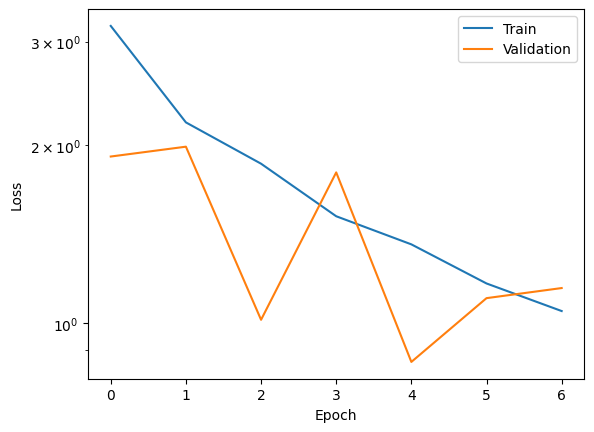

In [54]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

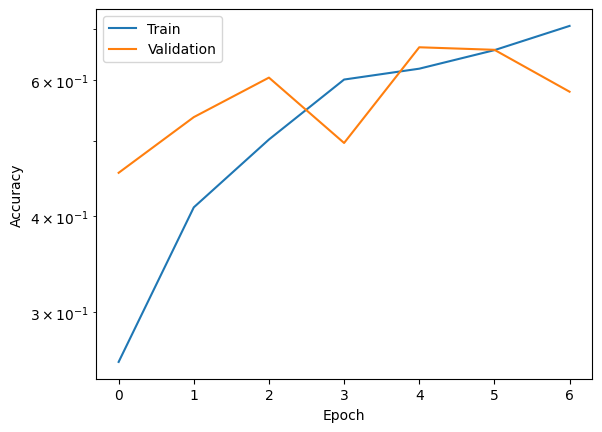

In [55]:
plt.semilogy(history.epoch,  history.history['accuracy'], label='Train')
plt.semilogy(history.epoch,  history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
Y_train_pred =new_model.predict_generator(train_batches,train_steps)

In [57]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [59]:
print(len(train_batches.classes))
print(len(y_train_pred))

1870
1864


#### Confusion matrix

In [58]:
cm_train = confusion_matrix(train_batches.classes, y_train_pred)

ValueError: Found input variables with inconsistent numbers of samples: [1870, 1864]

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [ ]:
Y_pred =new_model.predict_generator(test_batches,test_steps)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(test_batches.classes, y_pred)

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Save model

In [66]:
new_model.save('Resnet50_new.h5')